In [3]:
# Load the data
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
from scipy.stats import norm, ks_2samp

from scipy.stats import kstest
%matplotlib inline

# Introduction

In this notebook, we will walk through a hacker's approach to statistical thinking, as applied to network analysis.

## Statistics in a Nutshell

All of statistics can be broken down into two activities:

- Descriptively summarizing data. (a.k.a. **"descriptive statistics"**)
- Figuring out whether something happened by random chance. (a.k.a. **"inferential statistics"**)

### Descriptive Statistics

- Centrality measures: mean, median, mode
- Variance measures: inter-quartile range (IQR), variance and standard deviation

### Inferential Statistics

- Models of Randomness (see below)
- Hypothesis Testing
- Fitting Statistical Models

**Models of Randomness**

*Discrete Distributions:*

- Bernoulli: probability p of success in 1 try (e.g. one flip of coin).
- Binomial: probability p of success given n number of tries. `n * bernoulli trials` follows binomial distribution.
- Poisson: processes with a per-unit rate.

*Continuous Distributions:*

- Uniform: equal probability over the range of probable values. Can also be made discrete.
- Normal: everyone's favourite.

## Playing with Real Data!

In this notebook, we will statistically test whether a protein-protein interaction network follows an Erdos-Renyi random graph model or not. We will also see how to load real data into a NetworkX graph.

In [4]:
# Take a quick peek at what the edge list looks like.
!head datasets/moreno_propro/out.moreno_propro_propro.txt

% sym unweighted
% 2277 1870 1870
1 2
1 3
1 4
1 5
1 6
2 113
2 114
2 115


In [5]:
# Read in the data.
# Note from above that we have to skip the first two rows, and that there's no header column,and that the edges are
# delimited by spaces in between the nodes. Hence the syntax below:
propro = pd.read_csv('datasets/moreno_propro/out.moreno_propro_propro.txt', skiprows=2, header=None, delimiter=' ')
propro.columns = ['prot1_id', 'prot2_id']
propro.head()

,prot1_id,prot2_id
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6


**Exercise:** Put to work your knowledge of how the `networkx` API works. Add these edges into the graph.

In [6]:
proproG = nx.Graph()
proproG.add_edges_from(zip(propro['prot1_id'], propro['prot2_id']))

**Exercise:** Compute some basic descriptive statistics about the graph, namely:

- the number of nodes,
- the number of edges,
- the graph density,
- the distribution of degree centralities in the graph,


In [7]:
# Number of nodes:
len(proproG.nodes())

1870

In [8]:
# Number of edges:
len(proproG.edges())

2277

In [9]:
# Graph density:
nx.density(proproG)

0.0013029931073553016

In [10]:
# Degree centrality distribution:
list(nx.degree_centrality(proproG).values())

[0.002675227394328518,
 0.003210272873194221,
 0.010700909577314071,
 0.001070090957731407,
 0.002675227394328518,
 0.001070090957731407,
 0.0016051364365971105,
 0.0016051364365971105,
 0.0016051364365971105,
 0.001070090957731407,
 0.001070090957731407,
 0.0016051364365971105,
 0.002675227394328518,
 0.0005350454788657035,
 0.001070090957731407,
 0.013376136971642588,
 0.0037453183520599247,
 0.0005350454788657035,
 0.011235955056179775,
 0.0016051364365971105,
 0.001070090957731407,
 0.002675227394328518,
 0.001070090957731407,
 0.0016051364365971105,
 0.002140181915462814,
 0.020331728196896735,
 0.001070090957731407,
 0.0016051364365971105,
 0.0016051364365971105,
 0.004815409309791332,
 0.002675227394328518,
 0.0005350454788657035,
 0.001070090957731407,
 0.0005350454788657035,
 0.0005350454788657035,
 0.004815409309791332,
 0.009630818619582664,
 0.006420545746388442,
 0.0005350454788657035,
 0.002675227394328518,
 0.0016051364365971105,
 0.001070090957731407,
 0.000535045478865

**Exercise:** Make a histogram of the degree centralities for the protein-protein interaction graph, and the E-R graph.

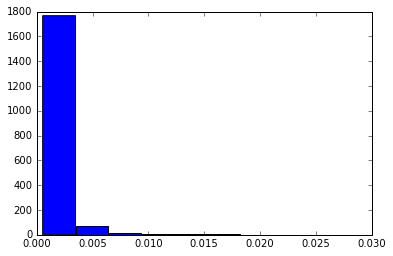

In [11]:
ppG_deg_centralities = list(nx.degree_centrality(proproG).values())
n, bins, patches = plt.hist(ppG_deg_centralities)

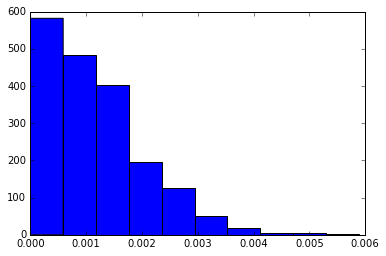

In [12]:
erG = nx.erdos_renyi_graph(n=len(proproG.nodes()), p=nx.density(proproG))
erG_deg_centralities = list(nx.degree_centrality(erG).values())
n, bins, patches = plt.hist(erG_deg_centralities)

From visualizing these two distributions, it is clear that they look very different. How do we quantify this difference, and statistically test whether the protein-protein graph could have arisen under an Erdos-Renyi model?

**Discuss this with your neighbors.**

One thing we might observe is that the variance, that is the "spread" around the mean, differs between the E-R model compared to our data. Therefore, we can compare variance of the data to the distribtion of variances under an E-R model.

This is essentially following the logic of statistical inference by 'hacking' (not to be confused with the statistical bad practice of p-hacking).

**Exercise:** Fill in the skeleton code below to simulate 100 E-R graphs.

In [13]:
# 1. Generate 100 E-R graph degree centrality variance measurements and store them.
# Takes ~50 seconds or so.
er_vars = np.zeros(100)  # variances for 1000 simulaed E-R graphs.
for i in range(100):
    erG = nx.erdos_renyi_graph(n=len(proproG.nodes()), p=nx.density(proproG))
    erG_deg_centralities = list(nx.degree_centrality(erG).values())
    er_vars[i] = np.var(erG_deg_centralities)

In [14]:
# 2. Compute the test statistic that is going to be used for the hypothesis test.
# Hint: numpy has a "var" function implemented that computes the variance of a distribution of data.
ppG_var = np.var(ppG_deg_centralities)

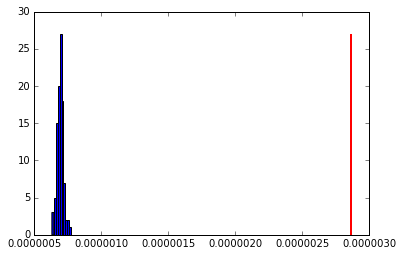

In [15]:
# Do a quick visual check
n, bins, patches = plt.hist(er_vars)
plt.vlines(ppG_var, ymin=0, ymax=max(n), color='red', lw=2)

Visually, it should be quite evident that the protein-protein graph did not come from an E-R distribution. Statistically, we can also use the hypothesis test procedure to quantitatively test this, using our simulated E-R data, 

In [16]:
# Conduct the hypothesis test.
ppG_var > np.percentile(er_vars, 99)  # we can only use the 99th percentile, because there are only 100 data points.

True

Another way to do this is to use the 2-sample Kolmogorov-Smirnov test implemented in the `scipy.stats` module. From the docs:

> This tests whether 2 samples are drawn from the same distribution. Note
that, like in the case of the one-sample K-S test, the distribution is
assumed to be continuous.
>
> This is the two-sided test, one-sided tests are not implemented.
The test uses the two-sided asymptotic Kolmogorov-Smirnov distribution.
>
> If the K-S statistic is small or the p-value is high, then we cannot
reject the hypothesis that the distributions of the two samples
are the same.

As an example to convince yourself that this test works, run the synthetic examples below.

In [17]:
# Scenario 1: Data come from the same distributions.
# Notice the size of the p-value.
dist1 = npr.random(size=(100))
dist2 = npr.random(size=(100))

ks_2samp(dist1, dist2)
# dist1

Ks_2sampResult(statistic=0.11000000000000004, pvalue=0.55601716622975639)

In [18]:
# Scenario 2: Data come from different distributions. 
# Note the size of the KS statistic, and the p-value.

dist1 = norm(3, 1).rvs(100)
dist2 = norm(5, 1).rvs(100)

ks_2samp(dist1, dist2)

Ks_2sampResult(statistic=0.78000000000000003, pvalue=7.1742366934117429e-28)

**Exercise:** Now, conduct the K-S test for one synthetic graph and the data.

In [19]:
# Now try it on the data distribution
ks_2samp(erG_deg_centralities, ppG_deg_centralities)

Ks_2sampResult(statistic=0.24545454545454548, pvalue=9.4511541688740658e-50)

Networks may be high-dimensional objects, but the logic for inference on network data essentially follows the same logic as for 'regular' data:

- Identify a model of 'randomness' that may model how your data may have been generated.
- Compute a "test statistic" for your data and the model.
- Compute the probability of observing the data's test statistic under the model.

# Further Reading

Jake Vanderplas' "Statistics for Hackers" slides: https://speakerdeck.com/jakevdp/statistics-for-hackers

Allen Downey's "There is Only One Test": http://allendowney.blogspot.com/2011/05/there-is-only-one-test.html